# MONITOREO: VOLUMEN

Funcionalidades para monitorear el volumen de los activos de renta variable. Entre ellas: Función que devuelve un gráfico con 3 paneles con los siguientes datos: 1) gráfico de velas del precio con una media móvil exponencial de 20 ruedas más el panel de volumen; 2) Un panel con dos medias móviles exponenciales de volumen parametrizables (una slow y una fast); 3) Un panel con el indicador técnico de Acumulación Distribución. Función que devuelve métricas de volumen nominal de un ticker seleccionado, para el período seleccionado y en función de indicadores técnicos tipo media móvil exponencial sobre el volumen, una rápida y una lenta, ambas parametrizables. Función sirve para analizar el flujo de dinero, es decir, los activos que más volumen (en dólares) están moviendo o han movido. Hay diferentes marcos temporales y rangos de tiempo de acumulación de volumen.

## INDICE DE FUNCIONES:
- plotVolume(ticker, period = "1y", m_fast = 10, m_slow = 30, interval = "1d"): Función que devuelve un gráfico con 3 paneles con los siguientes datos: 1) gráfico de velas del precio con una media móvil exponencial de 20 ruedas más el panel de volumen; 2) Un panel con dos medias móviles exponenciales de volumen parametrizables (una slow y una fast); 3) Un panel con el indicador técnico de Acumulación Distribución."

- analyzeVolume(ticker, period = "1y", m_fast = 10, m_slow = 30, interval = "1d"): Es una función que devuelve métricas de volumen nominal de un ticker seleccionado, para el período seleccionado y en función de indicadores técnicos tipo media móvil exponencial sobre el volumen, una rápida y una lenta, ambas parametrizables. Devuelve métricas de volumen.

- whereIsTheMoney(activos, timeframe):
    Esta función sirve para analizar el flujo de dinero, es decir, los activos que más volumen (en dólares) están moviendo o
    han movido. Hay diferentes marcos temporales y rangos de tiempo de acumulación de volumen.
        - Timeframes: "diario", "semanal" y "mensual";
        - activos: lista de activos especificada o bien las precargadas "adrs" (adrs), "cedears" (todos los activos de USA que coticen
        en Argentina), "sectors" (sectores vía etf), "lideres" (panel lider de ARG) o bien "general" (panel general de ARG).
    A su vez los resultados que retorna la función se agrupan por:
        - Si es rango diario: última rueda, últimas 5 ruedas (aprox 7d), últimas 21 ruedas (aprox 30d) y últimas 63 ruedas (aprox 90d)
        - Si es rango semanal: última semana, últimas 4 semanas (1m) y últimas 12 semanas (3m)
        - Si es rango mensual: último mes, últimos 3 meses y últimos 6 meses.
    A la vez que se ordena por volumen, también se visualizan otras dos importantes columnas: promedios para cada uno de los rangos
    temporales mencionados y cómo se ubica el monto operado de cada rango respecto al promedio (esto último resaltado en escala
    de colores para facilitar la identificación de entradas de dinero respecto de cada activo en particular / volumen anómalo).

In [1]:
# FUNCIONES NECESARIAS PARA OBTENER DATA FINANCIERA:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

def getDataYf(ticker, tipo, interval, data_from = None, data_to = None, period = None):
    """
    Es una función para descargar market data de Yahoo Finance con la librería yfinance.
    
    ## Inputs:
        >ticker: el nombre del ticker.
        >tipo: si es "no end" no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si es "end" es
        necesario indicar hasta cuánto (data_to). En ambos casos hay que indicar desde qué fecha (data_from). Si es "period" 
        no se indica ni desde cuándo ni hasta cuándo, sólo el argumento "period" con la cantidad de tiempo a obtener.
        >now : si es True, no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si se indica False, es
        necesario indicar hasta cuánto (data_to).
        >interval: el timeframe (ej. 1mo, 1h, 1d, 1wk, etc)
        >data_from: data desde qué fecha.
        >data_to: data hasta qué fecha (no inclusive el día). Sólo es aplicable si now == True.
        >period : en caso de tipo = "period", se pasa este argumento que refiere a la cantidad de tiempo a obtener. Ej. 1y, 2y, 3y, etc.
        
    ## Outputs:
        >series OHLC ajustadas del ticker.
    """
    import yfinance as yf
    import pandas as pd
    
    if tipo == "no end":
        data = yf.download(ticker, start = data_from, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "end":
        data = yf.download(ticker, start = data_from, end = data_to, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "period":
        data = yf.download(ticker, interval = interval, period = period, progress = False, auto_adjust = True)
    return data



def getDataYfMulti(activos, tipo, interval, data_from = None, data_to = None, period = None, swap = True):
    """
    Función para hacer batch requests (varios tickers a la vez), que será la fx que más voy a utilizar para market data.
    
    ## Inputs:
        >tickers: es una lista con los tickers de los cuales se va a obtener market data.
        >tipo: si es "no end" no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si es "end" es
        necesario indicar hasta cuánto (data_to). En ambos casos hay que indicar desde qué fecha (data_from). Si es "period" 
        no se indica ni desde cuándo ni hasta cuándo, sólo el argumento "period" con la cantidad de tiempo a obtener.
        >now : si es True, no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si se indica False, es
        necesario indicar hasta cuánto (data_to).
        >interval: el timeframe (ej. 1mo, 1h, 1d, 1wk, etc)
        >data_from: data desde qué fecha.
        >data_to: data hasta qué fecha (no inclusive el día). Sólo es aplicable si now == True.
        >period : en caso de tipo = "period", se pasa este argumento que refiere a la cantidad de tiempo a obtener. Ej. 1y, 2y, 3y, etc.
        >swap : si es True, divide el df en tickers y cada uno tiene su OHLC. Si es False, tenemos cada columna OHLC y dentro todos los tickers.
        
    ## Outputs:
        >series OHLC ajustadas del ticker.
    """
    import yfinance as yf
    import pandas as pd
    
    lideres_arg = ["ALUA.BA", "BBAR.BA", "BMA.BA", "BYMA.BA", "CEPU.BA", "COME.BA", "CRES.BA", "CVH.BA", "EDN.BA", 
                   "GGAL.BA", "LOMA.BA", "MIRG.BA", "PAMP.BA", "SUPV.BA", "TECO2.BA", "TGNO4.BA", "TGSU2.BA", "TRAN.BA", 
                   "TXAR.BA", "VALO.BA", "YPFD.BA"]

    general_arg = ["AGRO.BA", "AUSO.BA", "BHIP.BA", "BOLT.BA", "BPAT.BA", "CADO.BA", "CAPX.BA", "CARC.BA", "CECO2.BA", 
                   "CELU.BA", "CGPA2.BA", "CTIO.BA", "DGCU2.BA", "FERR.BA", "FIPL.BA", "GAMI.BA", "GCDI.BA", "GCLA.BA", 
                   "HARG.BA", "HAVA.BA", "INVJ.BA", "IRSA.BA", "LEDE.BA", "LONG.BA", "METR.BA", "MOLA.BA", "MOLI.BA", 
                   "MORI.BA", "OEST.BA", "PATA.BA", "RICH.BA", "RIGO.BA", "SAMI.BA", "SEMI.BA"]

    cedears = ["AAL", "AAPL", "ABBV", "ABEV", "ABNB", "ABT", "ADBE", "ADGO", "ADI", "ADP", "AEM", "AIG", "AMAT", "AMD", 
               "AMGN", "AMZN", "AOCA", "ARCO", "ARKK", "ASR", "AUY", "AVGO", "AXP", "AZN", "BA", "BA.C", "BABA", "BB", 
               "BBD", "BBV", "BCS", "BHP", "BIDU", "BIIB", "BIOX", "BITF", "BK", "BMY", "BNG", "BP", "BRFS", "BRKB", "BSBR", 
               "C", "CAAP", "CAH", "CAR", "CAT", "CBRD", "CDE", "CL", "COIN", "COST", "CRM", "CS", "CSCO", "CVX", "CX", "DD", 
               "DE", "DESP", "DIA", "DISN", "DOCU", "DOW", "E", "EA", "EBAY", "EEM", "EFX", "ERIC", "ERJ", "ETSY", "EWZ", "F", 
               "FCX", "FDX", "FMX", "FSLR", "GE", "GFI", "GGB", "GILD", "GLOB", "GLW", "GM", "GOLD", "GOOGL", "GPRK", "GRMN", 
               "GS", "HAL", "HD", "HL", "HMC", "HMY", "HOG", "HON", "HPQ", "HSBC", "HSY", "HUT", "HWM", "IBM", "IFF", "INTC", 
               "ITUB", "IWM", "JD", "JMIA", "JNJ", "JPM", "KMB", "KO", "KOFM", "LLY", "LMT", "LRCX", "LVS", "LYG", "MA", "MCD", 
               "MDT", "MELI", "META", "MMM", "MO", "MOS", "MRK", "MSFT", "MSI", "MSTR", "MU", "NEM", "NFLX", "NGG", "NIO", "NKE", 
               "NOKA", "NTCO", "NTES", "NUE", "NVDA", "NVS", "ORAN", "ORCL", "OXY", "PAAS", "PAC", "PANW", "PBI", "PBR", "PCAR", 
               "PEP", "PFE", "PG", "PHG", "PKS", "PSX", "PYPL", "QCOM", "QQQ", "RBLX", "RIO", "RTX", "SAN", "SAP", "SATL", "SBUX", 
               "SCCO", "SE", "SHEL", "SHOP", "SI", "SID", "SLB", "SNAP", "SNOW", "SONY", "SPGI", "SPOT", "SPY", "SQ", "SYY", "T", 
               "TEFO", "TEN", "TGT", "TM", "TMO", "TRIP", "TRVV", "TSLA", "TSM", "TTE", "TV", "TWLO", "TXN", "TXR", "UAL", "UBER", 
               "UGP", "UL", "UNH", "UNP", "UPST", "USB", "V", "VALE", "VIST", "VIV", "VOD", "VZ", "WBA", "WFC", "WMT", "X", "XLE", 
               "XLF", "XOM", "XP", "YY", "ZM"]

    adrs = ["BBAR", "BMA", "CEPU", "CRESY", "EDN", "GGAL", "IRS", "LOMA", "PAM", "SUPV", "TEO", "TGS", "TS", "TX", "YPF"]

    sectors = ["XLC", "XLP", "XLY", "XLF", "XLV", "XLI", "XLRE", "XLU", "XBI", "XLB", "XLK", "XLE"]
    
    precarga = ["lideres", "general", "cedears", "adrs", "sectores"]
    precarga_dict = {"lideres" : lideres_arg, "general" : general_arg, "cedears" : cedears, "adrs" : adrs, "sectores" : sectors}
    
    if activos in precarga:
        activos = precarga_dict[activos]
    
    if tipo == "no end":
        data = yf.download(activos, start = data_from, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "end":
        data = yf.download(activos, start = data_from, end = data_to, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "period":
        data = yf.download(activos, interval = interval, period= period, progress = False, auto_adjust = True)
    
    if swap:
        #data = data.swaplevel(i = 0, j = 1, axis = 1)
        # Algoritmo para procesar el MultipleTicker download de yfinance
        dicto = {}
        low = data["Low"]
        high = data["High"]
        close = data["Close"]
        open = data["Open"]
        volume = data["Volume"]

        tickers = list(data["Close"].columns)

        for ticker in tickers:
            dicto[ticker] = {
                "Open" : open[ticker],
                "High" : high[ticker],
                "Low" : low[ticker],
                "Close" : close[ticker],
                "Volume" : volume[ticker]
            }

            dicto[ticker] = pd.DataFrame(dicto[ticker])
        return dicto
    return data

In [3]:
# FUNCIONALIDADES PRINCIPALES DEL MÓDULO:

def plotVolume(ticker, period = "1y", m_fast = 10, m_slow = 30, interval = "1d"):
    """ Función que devuelve un gráfico con 3 paneles con los siguientes datos: 1) gráfico de velas del precio con una media móvil exponencial
    de 20 ruedas más el panel de volumen; 2) Un panel con dos medias móviles exponenciales de volumen parametrizables (una slow y una fast);
    3) Un panel con el indicador técnico de Acumulación Distribución."
    
    # Inputs:
        - ticker;
        - period: período de market data. Ej.: 1 año es "1y", 6 meses es "6mo", etc.
        - m_fast: longitud de la MM rápida de volumen;
        - m_slow: longitud de la MM lenta de volumen;
        - interval: time frame de las velas/market data (ej. "1d" es día, "1w" es 1 semana, etc.).
    
    # Output:
        - gráfico conforme descripción de función.
    """
    
    import pandas_ta as ta
    import mplfinance as mpf
    df = getDataYf(ticker, tipo = "period", interval = interval, period = period)
    # Defino datos de estrategia
    MyStrategy = ta.Strategy(
        name = "volumeAnalyzer",
        ta = [
            {"kind" : "adosc", "length" : 20},
            {"kind" : "ema", "close" : "Close", "length" : 20, "prefix" : "mmP"},
            {"kind" : "ema", "close" : "volume", "length" : m_fast, "prefix" : "mmV"},   # EMA rápida de Volumen
            {"kind" : "ema", "close" : "volume", "length" : m_slow, "prefix" : "mmV"},   # EMA lenta de Volumen
        ]
    )
    # Calculo el dataframe con datos de estrategia
    df.ta.strategy(MyStrategy)
    df = df.dropna().round(2)
    
    indicadores_up0 = df[[f"mmP_EMA_20"]]
    indicadores_up = df[["ADOSC_3_10"]]
    indicadores_down = df[[f"mmV_EMA_{m_fast}", f"mmV_EMA_{m_slow}"]]
    add0 = mpf.make_addplot(indicadores_up0, panel = 0)
    add1 = mpf.make_addplot(indicadores_up, panel = 3)
    add2 = mpf.make_addplot(indicadores_down, panel = 2)

    plot = mpf.plot(df, 
                    volume=True, 
                    type = "candle", 
                    figratio=(14,7), 
                    style="yahoo", 
                    addplot=[add0, add1, add2], 
                    title = f"{ticker} - {df.index[0].strftime('%m/%d/%Y')} al {df.index[-1].strftime('%m/%d/%Y')}", 
                    panel_ratios=(3,3,3,3))
    return plot


def analyzeVolume(ticker, period = "1y", m_fast = 10, m_slow = 30, interval = "1d"):
    """
    Es una función que devuelve métricas de volumen nominal de un ticker seleccionado, para el período seleccionado y en función de
    indicadores técnicos tipo media móvil exponencial sobre el volumen, una rápida y una lenta, ambas parametrizables. Devuelve métricas
    de volumen.
    
    # Inputs:
        - ticker: ticker;
        - period: periodo de market data. Ej. "1y" es 1 año, o "1mo" es 1 mes;
        - m_fast: ventana de ruedas de la media móvil rápida de volumen;
        - m_slow: ventana de ruedas de la media móvil slow de volumen;
        - interval: timeframe de las ruedas;
    # Outputs:
        - Una lista con tres componentes:
            - df: el dataframe con toda la data, por si se necesita;
            - metrics: las métricas de volumen calculadas en formato diccionario;
            - report: el reporte escrito con el estado de situación del volumen según las métricas (metrics).
    """
    
    import pandas_ta as ta
    import numpy as np
    
    df = getDataYf(ticker, tipo = "period", interval = interval, period = period)
    # Defino datos de estrategia
    MyStrategy = ta.Strategy(
        name = "volumeAnalyzer",
        ta = [
            {"kind" : "adosc", "length" : 20},
            {"kind" : "ema", "close" : "Close", "length" : 20, "prefix" : "mmP"},
            {"kind" : "ema", "close" : "volume", "length" : m_fast, "prefix" : "mmV"},   # EMA rápida de Volumen
            {"kind" : "ema", "close" : "volume", "length" : m_slow, "prefix" : "mmV"},   # EMA lenta de Volumen
        ]
    )
    # Calculo el dataframe con datos de estrategia
    df.ta.strategy(MyStrategy)
    df["xVolFast"] = df["Volume"] / df[f"mmV_EMA_{m_fast}"]   # Cuántos X el volumen del día respecto al promedio según EMA Fast
    df["xVolSlow"] = df["Volume"] / df[f"mmV_EMA_{m_slow}"]   # Cuántos X el volumen del día respecto al promedio según EMA Slow
    df["catVol"] = np.where((df[f"mmV_EMA_{m_fast}"] - df[f"mmV_EMA_{m_slow}"]) > 0, "Volumen Alto", "Volumen Bajo")
    df = df.dropna().round(2)
    metrics = {"date" : df.index[-1].strftime('%d/%m/%Y'),
               "catVol": df["catVol"][-1], 
               "xVolFast" :  df["xVolFast"][-1], 
               "xVolSlow" :  df["xVolSlow"][-1], 
               "MMVolFast" : df[f"mmV_EMA_{m_fast}"][-1],
               "MMVolSlow" : df[f"mmV_EMA_{m_slow}"][-1],
               "volume" : df["Volume"][-1]
              }
    
    report = f"""Hoy {df.index[-1].strftime('%m/%d/%Y')}: el volumen es de {metrics['volume']} nominales, \
    siendo el volumen promedio últimos {m_fast} ruedas de {metrics['MMVolFast']} nominales, \
    el volumen promedio últimos {m_fast} ruedas de {metrics['MMVolFast']} nominales, \
    el volumen promedio últimos {m_slow} ruedas de {metrics['MMVolSlow']} nominales,\
    por lo que es una categoría de {metrics['catVol']}. \
    El volumen actual es un {metrics['xVolFast']}x del volumen promedio de las {m_fast}\
    ruedas y de {metrics['xVolSlow']}x del volumen promedio de las {m_slow} ruedas"""
    
    return [df, metrics, report]
    

def whereIsTheMoney(activos, timeframe):
    """
    Esta función sirve para analizar el flujo de dinero, es decir, los activos que más volumen (en dólares) están moviendo o
    han movido. Hay diferentes marcos temporales y rangos de tiempo de acumulación de volumen.
        - Timeframes: "diario", "semanal" y "mensual";
        - activos: lista de activos especificada o bien las precargadas "adrs" (adrs), "cedears" (todos los activos de USA que coticen
        en Argentina), "sectors" (sectores vía etf), "lideres" (panel lider de ARG) o bien "general" (panel general de ARG).
    A su vez los resultados que retorna la función se agrupan por:
        - Si es rango diario: última rueda, últimas 5 ruedas (aprox 7d), últimas 21 ruedas (aprox 30d) y últimas 63 ruedas (aprox 90d)
        - Si es rango semanal: última semana, últimas 4 semanas (1m) y últimas 12 semanas (3m)
        - Si es rango mensual: último mes, últimos 3 meses y últimos 6 meses.
    A la vez que se ordena por volumen, también se visualizan otras dos importantes columnas: promedios para cada uno de los rangos
    temporales mencionados y cómo se ubica el monto operado de cada rango respecto al promedio (esto último resaltado en escala
    de colores para facilitar la identificación de entradas de dinero respecto de cada activo en particular / volumen anómalo).
    
    # Inputs:
        - activos: lista de activos especificada o bien las precargadas "adrs" (adrs), "cedears" (todos los activos de USA que coticen
        en Argentina), "sectors" (sectores vía etf), "lideres" (panel lider de ARG) o bien "general" (panel general de ARG).
        - timeframe: "diario", "semanal" y "mensual"
    
    # Outputs:
        - Si el TF es diario: df_vol_actual, df_vol_utl5r, df_vol_utl21r, df_vol_utl63r,
                               df_vol_actual_est, df_vol_ult5r_est, df_vol_ult21r_est, df_vol_ult63r_est.
        - Si el TF es semanal: df_vol_actual, df_vol_ult4s, df_vol_ult12s, 
                                df_vol_actual_est, df_vol_ult4s_est, df_vol_ult12s_est.
        - Si el TF es mensual: df_vol_actual, df_vol_ult3m, df_vol_ult6m, 
                                df_vol_actual_est, df_vol_ult3m_est, df_vol_ult6m_est.
                                
        Donde: "df" es dataframe/tabla con columnas de volumen, promedio y volumen / promedio y "r" es ruedas/días,
        "s" es semanas y "m" es meses.
    """
    
    import pandas_ta as ta
    import numpy as np
    import pandas as pd
    from datetime import datetime
    
    if timeframe == "diario":
        interval = "1d"
        period = "1y"
    elif timeframe == "semanal":
        interval = "1wk"
        period = "2y"
    elif timeframe == "mensual":
        interval = "1mo"
        period = "4y"
    else:
        return "timeframe incorrecto, elegir 'diario', 'semanal' o 'mensual'"

    
    data = getDataYfMulti(activos, tipo = "period", interval = interval, period = period, swap = True)
    
    
    if activos in ["lideres", "general"]:
        local = getDataYf("YPFD.BA", tipo = "period", interval = interval, period = period)["Close"]
        adr = getDataYf("YPF", tipo = "period", interval = interval, period = period)["Close"]
        ccl = (local / adr).to_frame().round(2)
        ccl.columns = ['CCL']
        for activo in data.keys():
            data[activo]["Close"] = data[activo]["Close"].div(ccl['CCL'], axis=0)
    
    dict_vol_actual = {} # hoy / esta semana / este mes (según timeframe)
    
    # Diccionarios para timeframe diario:
    if timeframe == "diario":
        dict_vol_ult5r = {} # última semana (sólo para timeframe diario)
        dict_vol_ult21r = {}  # último mes calendario (sólo para timeframe diario)
        dict_vol_ult63r = {}  # últimos 3 meses calendario (sólo para timeframe diario)
    
    if timeframe == "semanal":
        dict_vol_ult4s = {} # último mes calendario (sólo para timeframe semanal)
        dict_vol_ult12s = {} # últimos 3 meses calendario (sólo para timeframe semanal)
        
    if timeframe == "mensual":
        dict_vol_ult3m = {} # últimos 3 meses (sólo para timeframe mensual)
        dict_vol_ult6m = {} # últimos 6 meses (sólo para timeframe mensual)

    i = 0
    
    for activo in data.keys():
        try:
            data[activo] = data[activo][data[activo]["Volume"] != 0]
            data[activo]["volumenUsd"] = (data[activo]["Close"] * data[activo]["Volume"]) / 1000000     # Expresado en Millones de USD
            vol_prom = data[activo]["volumenUsd"].mean()
            dict_vol_actual[activo] = {"volActual" : data[activo]["volumenUsd"][-1], "volProm" : vol_prom}
            # Calculamos volumen de distintas acumulaciones de ruedas según timeframe y también un promedio para esos rangos
            # Esto último permite poner en relación el volumen respecto al promedio (para cada activo), al margen de ordenar
            # los activos por volumen operado, por rango.
            if timeframe == "diario":
                data[activo]["volUlt5r"] = data[activo]["volumenUsd"].rolling(5).sum()
                prom5r = data[activo]["volUlt5r"].mean()
                data[activo]["volUlt21r"] = data[activo]["volumenUsd"].rolling(21).sum()
                prom5r = data[activo]["volUlt21r"].mean()
                data[activo]["volUlt63r"] = data[activo]["volumenUsd"].rolling(63).sum()
                prom5r = data[activo]["volUlt63r"].mean()
                
                
            elif timeframe == "semanal":
                data[activo]["volUlt4s"] = data[activo]["volumenUsd"].rolling(4).sum()
                prom4s = data[activo]["volUlt4s"].mean()
                data[activo]["volUlt12s"] = data[activo]["volumenUsd"].rolling(12).sum()
                prom12s = data[activo]["volUlt12s"].mean()
                
                
            else:
                data[activo]["volUlt3m"] = data[activo]["volumenUsd"].rolling(3).sum()
                prom3m = data[activo]["volUlt3m"].mean()
                data[activo]["volUlt6m"] = data[activo]["volumenUsd"].rolling(6).sum()
                prom6m = data[activo]["volUlt6m"].mean()
                              
                
            # Si el volumen estuviera expresado en pesos (caso de panel líder o panel general), convertimos a dólar CCL:
            if activos in ["lideres", "general"]:
                local = getDataYf("YPFD.BA", tipo = "period", period = period, interval = interval)["Close"]
                adr = getDataYf("YPF", tipo = "period", period = period, interval = interval)["Close"]
                ccl = (local / adr).to_frame().round(2)
                ccl.columns = ['CCL']
                data[activo]["volumenUsd"] = data[activo]["volumenUsd"].div(ccl['CCL'], axis=0)
            else:
                # Sino, no hacemos nada, ya queda expresado en dólares (ej. con "adrs" y "cedears")
                pass
            
            # Guardamos volumen válido para todos los timeframe (última rueda, última semana o último mes)
            dict_vol_actual[activo] = {"vol" : data[activo]["volumenUsd"][-1], "prom" : vol_prom, "xProm" : data[activo]["volumenUsd"][-1] / vol_prom}
            
            # Guardamos data de distintos períodos según dataframe:
            if timeframe == "diario":
                dict_vol_ult5r[activo] = {"vol5r" : data[activo]["volUlt5r"][-1], "prom5r" : prom5r, "xProm" : data[activo]["volUlt5r"][-1] / prom5r}
                dict_vol_ult21r[activo] = {"vol21r" : data[activo]["volUlt21r"][-1], "prom21r" : prom21r, "xProm" : data[activo]["volUlt21r"][-1] / prom21r}
                dict_vol_ult63r[activo] = {"vol63r" : data[activo]["volUlt63r"][-1], "prom63r" : prom63r, "xProm" : data[activo]["volUlt63r"][-1] / prom63r}
                
            elif timeframe == "semanal":
                dict_vol_ult4s[activo] = {"vol4s" : data[activo]["volUlt4s"][-1], "prom4s" : prom4s, "xProm" : data[activo]["volUlt4s"][-1] / prom4s}
                dict_vol_ult12s[activo] = {"vol12s" : data[activo]["volUlt12s"][-1], "prom12s" : prom12s, "xProm" : data[activo]["volUlt12s"][-1] / prom12s}
                
            else: # Si es Mensual
                dict_vol_ult3m[activo] = {"vol3m" : data[activo]["volUlt3m"][-1], "prom3m" : prom3m, "xProm" : data[activo]["volUlt3m"][-1] / prom3m}
                dict_vol_ult6m[activo] ={"vol6m" : data[activo]["volUlt6m"][-1], "prom6m" : prom6m, "xProm" : data[activo]["volUlt6m"][-1] / prom6m}
            
            i += 1
            print(f"Procesando {i} de {len(list(data.keys()))} activos [{activo}]")
        except:
            continue
      
    
    # Convertimos diccionarios en dataframes
    
    df_vol_actual = pd.DataFrame(dict_vol_actual).transpose()    \
    .rename(columns = {"vol" : "volActual", "prom" : "volProm"}) \
    .sort_values(by = "volActual", ascending = False) \
    .round(2)

    df_vol_actual_est = df_vol_actual.style.background_gradient(subset = ["xProm"], cmap = "Greens") \
        .format('{:.2f}')
    
    if timeframe == "diario":
        df_vol_ult5r = pd.DataFrame(dict_vol_ult5r).transpose()    \
        .rename(columns = {"vol" : "vol5r", "prom" : "volProm5r"}) \
        .sort_values(by = "vol5r", ascending = False) \
        .round(2)
        
        df_vol_ult21r = pd.DataFrame(dict_vol_ult21r).transpose()    \
        .rename(columns = {"vol" : "vol21r", "prom" : "volProm21r"}) \
        .sort_values(by = "vol21r", ascending = False) \
        .round(2)
        
        df_vol_ult63r = pd.DataFrame(dict_vol_ult63r).transpose()    \
        .rename(columns = {"vol" : "vol63r", "prom" : "volProm63r"}) \
        .sort_values(by = "vol63r", ascending = False) \
        .round(2)
        
        df_vol_ult5r_est = df_vol_ult5r.style.background_gradient(subset = ["xProm"], cmap = "Greens") \
        .format('{:.2f}')
        
        df_vol_ult21r_est = df_vol_ult21r.style.background_gradient(subset = ["xProm"], cmap = "Greens") \
        .format('{:.2f}')
        
        df_vol_ult63r_est = df_vol_ult63r.style.background_gradient(subset = ["xProm"], cmap = "Greens") \
        .format('{:.2f}')
         
        return (df_vol_actual, df_vol_utl5r, df_vol_utl21r, df_vol_utl63r,
               df_vol_actual_est, df_vol_ult5r_est, df_vol_ult21r_est, df_vol_ult63r_est)
    
    elif timeframe == "semanal":
        
        df_vol_ult4s = pd.DataFrame(dict_vol_ult4s).transpose()    \
        .rename(columns = {"vol" : "vol4s", "prom" : "volProm4s"}) \
        .sort_values(by = "vol4s", ascending = False) \
        .round(2)
        
        df_vol_ult12s = pd.DataFrame(dict_vol_ult12s).transpose()    \
        .rename(columns = {"vol" : "vol12s", "prom" : "volProm12s"}) \
        .sort_values(by = "vol12s", ascending = False) \
        .round(2)
        
        df_vol_ult4s_est = df_vol_ult4s.style.background_gradient(subset = ["xProm"], cmap = "Greens") \
        .format('{:.2f}')
        
        df_vol_ult12s_est = df_vol_ult12s.style.background_gradient(subset = ["xProm"], cmap = "Greens") \
        .format('{:.2f}')
        
        
        return (df_vol_actual, df_vol_ult4s, df_vol_ult12s, 
                df_vol_actual_est, df_vol_ult4s_est, df_vol_ult12s_est)
        
    else:
        
        df_vol_ult3m = pd.DataFrame(dict_vol_ult3m).transpose()    \
        .rename(columns = {"vol" : "vol3m", "prom" : "volProm3m"}) \
        .sort_values(by = "vol3m", ascending = False) \
        .round(2)
        
        df_vol_ult6m = pd.DataFrame(dict_vol_ult6m).transpose()    \
        .rename(columns = {"vol" : "vol6m", "prom" : "volProm6m"}) \
        .sort_values(by = "vol6m", ascending = False) \
        .round(2)
        
        df_vol_ult3m_est = df_vol_ult3m.style.background_gradient(subset = ["xProm"], cmap = "Greens") \
        .format('{:.2f}')
        
        df_vol_ult6m_est = df_vol_ult6m.style.background_gradient(subset = ["xProm"], cmap = "Greens") \
        .format('{:.2f}')
        
        return (df_vol_actual, df_vol_ult3m, df_vol_ult6m, 
                df_vol_actual_est, df_vol_ult3m_est, df_vol_ult6m_est)

In [4]:
df, metrics, report = analyzeVolume("TSLA", period = "1y", m_fast = 10, m_slow = 30, interval = "1d")

In [5]:
# analyzeVolume - output - dataframe (TSLA)
df

,Open,High,Low,Close,Volume,ADOSC_3_10,mmP_EMA_20,mmV_EMA_10,mmV_EMA_30,xVolFast,xVolSlow,catVol
Date,,,,,,,,,,,,
2023-03-06,198.54,198.60,192.30,193.81,128100100,85994096.95,193.78,1.614992e+08,1.923048e+08,0.79,0.67,Volumen Bajo
2023-03-07,191.38,194.20,186.10,187.71,148125800,36857047.63,193.20,1.590677e+08,1.894545e+08,0.93,0.78,Volumen Bajo
2023-03-08,185.04,186.50,180.00,182.00,151897800,-5184004.85,192.14,1.577641e+08,1.870315e+08,0.96,0.81,Volumen Bajo
2023-03-09,180.25,185.18,172.51,172.92,170023800,-72508550.60,190.31,1.599931e+08,1.859342e+08,1.06,0.91,Volumen Bajo
2023-03-10,175.13,178.29,168.44,173.44,191488900,-92530824.39,188.70,1.657196e+08,1.862926e+08,1.16,1.03,Volumen Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,214.86,215.67,212.01,215.55,103164400,-7741930.22,235.46,1.059482e+08,1.097265e+08,0.97,0.94,Volumen Bajo
2024-01-18,216.88,217.45,208.74,211.88,108595400,-556542.09,233.22,1.064295e+08,1.096536e+08,1.02,0.99,Volumen Bajo
2024-01-19,209.99,213.19,207.56,212.19,102095800,23378592.72,231.21,1.056415e+08,1.091660e+08,0.97,0.94,Volumen Bajo


In [6]:
# analyzeVolume - output - metrics (TSLA)
metrics

{'date': '23/01/2024',
 'catVol': 'Volumen Bajo',
 'xVolFast': 0.1,
 'xVolSlow': 0.08,
 'MMVolFast': 89794724.96,
 'MMVolSlow': 103194274.24,
 'volume': 8596115}

In [7]:
# analyzeVolume - output - report (TSLA)
report

'Hoy 01/23/2024: el volumen es de 8596115 nominales,     siendo el volumen promedio últimos 10 ruedas de 89794724.96 nominales,     el volumen promedio últimos 10 ruedas de 89794724.96 nominales,     el volumen promedio últimos 30 ruedas de 103194274.24 nominales,    por lo que es una categoría de Volumen Bajo.     El volumen actual es un 0.1x del volumen promedio de las 10    ruedas y de 0.08x del volumen promedio de las 30 ruedas'

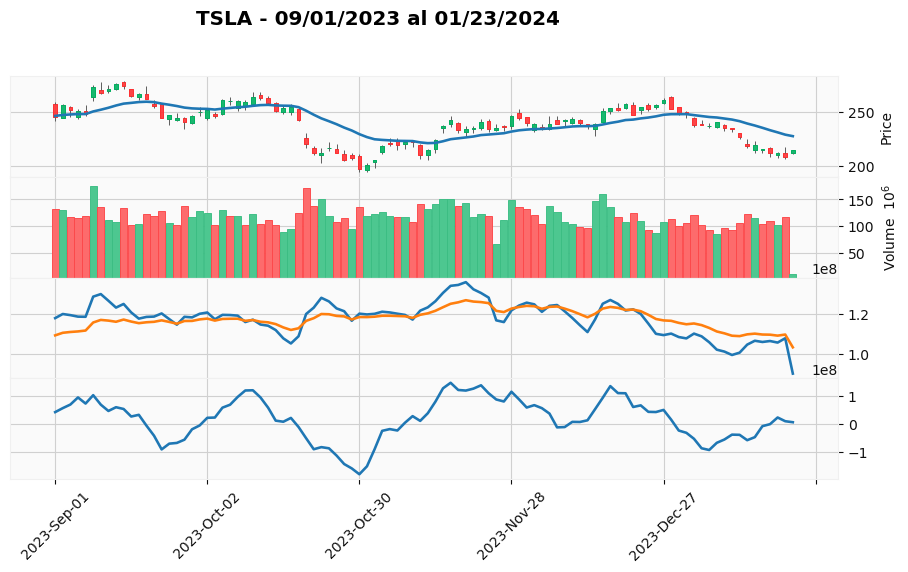

In [8]:
plotVolume("TSLA", period = "6mo", m_fast = 10, m_slow = 30, interval = "1d")

In [9]:
actual, ult4s, ult12s, actual_est, ult4s_est, ult12s_est = whereIsTheMoney(activos = "adrs", timeframe = "semanal")

Procesando 1 de 15 activos [BBAR]
Procesando 2 de 15 activos [BMA]
Procesando 3 de 15 activos [CEPU]
Procesando 4 de 15 activos [CRESY]
Procesando 5 de 15 activos [EDN]
Procesando 6 de 15 activos [GGAL]
Procesando 7 de 15 activos [IRS]
Procesando 8 de 15 activos [LOMA]
Procesando 9 de 15 activos [PAM]
Procesando 10 de 15 activos [SUPV]
Procesando 11 de 15 activos [TEO]
Procesando 12 de 15 activos [TGS]
Procesando 13 de 15 activos [TS]
Procesando 14 de 15 activos [TX]
Procesando 15 de 15 activos [YPF]


In [14]:
#  whereIsTheMoney - output - situación actual (con estilos)
actual_est

,volActual,volProm,xProm
TS,67.30,315.98,0.21
GGAL,43.64,41.44,1.05
YPF,42.43,108.23,0.39
BMA,32.14,22.82,1.41
PAM,8.51,25.33,0.34
BBAR,7.89,12.44,0.63
TX,6.33,55.87,0.11
SUPV,5.50,5.72,0.96
TEO,5.23,3.29,1.59
LOMA,4.58,6.47,0.71


In [15]:
#  whereIsTheMoney - output - situación últimas 4 semanas (con estilos)
ult4s_est

,vol4s,prom4s,xProm
TS,975.08,1269.12,0.77
YPF,475.22,437.01,1.09
GGAL,229.82,165.72,1.39
BMA,136.26,90.73,1.50
TX,104.23,218.86,0.48
PAM,86.95,102.68,0.85
BBAR,51.50,50.14,1.03
SUPV,48.40,22.77,2.13
TGS,36.70,35.44,1.04
CEPU,36.30,23.53,1.54


In [16]:
#  whereIsTheMoney - output - situación últimas 12 semanas (con estilos)
ult12s_est

,vol12s,prom12s,xProm
TS,3509.74,3773.42,0.93
YPF,2877.44,1278.41,2.25
GGAL,1043.36,480.06,2.17
BMA,581.86,262.45,2.22
PAM,513.43,303.17,1.69
TX,376.90,618.84,0.61
BBAR,275.47,147.34,1.87
TGS,218.95,103.41,2.12
SUPV,193.63,63.31,3.06
CEPU,158.22,67.42,2.35


In [11]:
#  whereIsTheMoney - output - situación actual
actual

,volActual,volProm,xProm
TS,67.30,315.98,0.21
GGAL,43.64,41.44,1.05
YPF,42.43,108.23,0.39
BMA,32.14,22.82,1.41
PAM,8.51,25.33,0.34
BBAR,7.89,12.44,0.63
TX,6.33,55.87,0.11
SUPV,5.50,5.72,0.96
TEO,5.23,3.29,1.59
LOMA,4.58,6.47,0.71


In [12]:
#  whereIsTheMoney - output - situación últimas 4 semanas
ult4s

,vol4s,prom4s,xProm
TS,975.08,1269.12,0.77
YPF,475.22,437.01,1.09
GGAL,229.82,165.72,1.39
BMA,136.26,90.73,1.50
TX,104.23,218.86,0.48
PAM,86.95,102.68,0.85
BBAR,51.50,50.14,1.03
SUPV,48.40,22.77,2.13
TGS,36.70,35.44,1.04
CEPU,36.30,23.53,1.54


In [13]:
#  whereIsTheMoney - output - situación últimas 12 semanas
ult12s

,vol12s,prom12s,xProm
TS,3509.74,3773.42,0.93
YPF,2877.44,1278.41,2.25
GGAL,1043.36,480.06,2.17
BMA,581.86,262.45,2.22
PAM,513.43,303.17,1.69
TX,376.90,618.84,0.61
BBAR,275.47,147.34,1.87
TGS,218.95,103.41,2.12
SUPV,193.63,63.31,3.06
CEPU,158.22,67.42,2.35
